# Reddit NLP Data Cleaning & EDA

## Overview

This notebook contains the data modelling portion of the Reddit NLP Project to create a model distinguishing posts between 2 subreddits. More detailed information can be found in the Data Cleaning and EDA notebook.

Various models will be trained on the combined dats set featuring the following subreddits, to see if they are able to distinguish the two:
- r/personalfinance
- r/wallstreetbets

Models tested include:
- Naive Bayes
- Random Forest
- Extremely Randomized Trees
- ADA Boost

Word modifications used include:
- Lemmatizing
- Stemming

## Contents
- [Model Summary](#Model-Summary)
- [Import Data](#Import-Data)
- [Functions](#Functions)
- [Naive Bayes Models](#Saving-Data-for-Model-Testing)

## Import Data

In [1]:
# Initial imports 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re                             # regex


# SKlearn imports for modelling and calculating modelling metrics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix, 
    accuracy_score, 
    plot_roc_curve,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS


# Nltk imports for Natural Language Processing

from nltk.corpus import stopwords


# Adjustments to set a plot style, and show plots once created

plt.style.use('bmh')
%matplotlib inline  

In [2]:
reddit_clean = pd.read_csv('datasets/reddit_clean.csv').drop(columns = ['Unnamed: 0'])

## Functions

In [3]:
def words_of_interest(vec, initial_word_list, suptitle, list_of_titles, fig_size):
    '''function takes an instantiated feature extractor (countvectorizer) and:
    1. creates a dataseries of words 
    2. returns the 25 most common and least common words in the dataseries
    3. plots a bar plot of the 15 most and least commong words'''
    converted_word_list = vec.fit_transform(initial_word_list)                        # Transforms dataseries
    sum_words = converted_word_list.sum(axis=0)                                       # Sum along the column
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # List of tuples (word, freq)    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)               # Sorts list in descending order
    word_pd = pd.DataFrame(
        columns = ['word', 'frequency'],
        data = words_freq
    )
    print(f'The top 25 most common terms are: \n{words_freq[:25]}',
          '\n---------------\n\n',
          f'The top 25 least common terms are: \n{words_freq[:-25:-1]}',
         '\n---------------\n')
    
    fig, axs = plt.subplots(1, 2, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 18)
    fig.tight_layout(pad = 0, w_pad = 8.0, h_pad = 1.0 , rect = [0, 0, 1, 0.95]) 
    
    axs[0].set_title(list_of_titles[0], fontsize = 12)
    sns.barplot(
        ax = axs[0],
        y = 'word',
        x = 'frequency',
        palette = 'dark:blue',
        data = word_pd.head(15)
    )
    
    axs[1].set_title(list_of_titles[1], fontsize = 12)
    sns.barplot(
        ax = axs[1],
        y = 'word',
        x = 'frequency',
        palette = 'light:blue',
        data = word_pd.tail(15)
    ) 
    
    
def to_table(model_name, model, mods = None):
    '''Adds a given model to the summary dictionary'''
    
    if 'cvec' in str(model):
        vec = 'Count Vectorizer'
    elif 'tvec' in str(model):
        vec = 'TF-IDF'
    
    if mods == 'lem':
        word_mod = 'Lemmatized'
        Xtestscore = X_lem_test
        ytestscore = y_lem_test
    elif mods == 'stem':
        word_mod = 'Stemmed'
        Xtestscore = X_stem_test
        ytestscore = y_stem_test
    else:
        word_mod = 'Unmodified'
        Xtestscore = X_test
        ytestscore = y_test
    
    summary_table[(str(model_name) + ' ' + vec + ' ' + word_mod)] = {
        'Model': str(model_name),
        'Word Vectorizer': vec,  
        'Best Features': str(model.best_params_),
        'Word Modifications': word_mod,
        'Train Accuracy Score': str(model.best_score_),
        'Test Accuracy Score': str(model.score(Xtestscore, ytestscore))
    }

# Creating Empty Summary Dictionary 
summary_table = {}


def get_predictions(model, x_final, y_final, threshold):
    '''Print the various confusion matrix values for a given model, data set and threshold'''
    probs = model.predict_proba(x_final)[:,1]
    predictions = [0 if prob < threshold else 1 for prob in probs]
    confusion_matrix(y_final, predictions)
    tn, fp, fn, tp = confusion_matrix(y_final, predictions).ravel()
    print(f'For the threshold of {threshold}:',
          f'\nTrue Negatives: {tn}',
          f'\nFalse Positives: {fp}',
          f'\nFalse Negatives: {fn}',
          f'\nTrue Positives: {tp}',
          "\n--------------------------",
          f'\nSpecificity is {(tn) / (tn + fp)}',
          f'\nSensitivity score is {recall_score(y_final, predictions)}',
          f'\nPrecision score is {precision_score(y_final, predictions)}')

In [4]:
# Including various subreddit related terms in the stopwords

stop_words = frozenset(['personalfinance', 'personal', 'finance', 'wallstreetbets', 'bets', 'wallstreet', 'wsb',
                        'wall street', 'gme', 'gamestop', 'amc', 'tmc', 'ast',
                        'robinhood', 'opad', 'oscr', 'pjpg', 'webp'])

english_stop_words = ENGLISH_STOP_WORDS.union(stop_words)

Alongside the two subreddit names and amalgamations thereof, the following stocks tickers were also removed:

|Company|Ticker|
|--|--|
|Gamestop|GME|
|AMEC Theatres|AMC|
|AST SpaceMobile|AST|
|The Metals Company| TMC|
|Offerpad|OPAD|
|Oscar Hetlh|OSCR|

As well as robinhood, which surged as a trend in the recent past.

### Computational Speed

This will control the n_jobs parameter for the gridsearches

In [5]:
comp_speed = -1

## Naive Bayes Models

### Count Vectorization

#### Unmodified Words

In [6]:
X = reddit_clean['words_clean']
y = reddit_clean['is_wallstreetbets']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

In [7]:
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [8]:
pipe_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__stop_words': [english_stop_words],
}

In [9]:
gs_cvec = GridSearchCV(
    pipe_cvec,
    param_grid = pipe_cvec_params,
    cv = 5,
    n_jobs = comp_speed
)

In [10]:
gs_cvec.fit(X_train, y_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am', 'amc',
                                                         

In [11]:
print(f'The accuracy score on the training set with the unmodified words is: \n{gs_cvec.best_score_}.',
      '\n---------------------\n\n',
      f'The best parameters on the gridsearch with the unmodified words is: \n{gs_cvec.best_params_}.',
      '\n---------------------\n\n',
      f'The accuracy score on the test set with the unmodified words is: \n{gs_cvec.score(X_test, y_test)}.',
      '\n---------------------')

to_table('Naive Bayes', gs_cvec)

The accuracy score on the training set with the unmodified words is: 
0.9502597891996208. 
---------------------

 The best parameters on the gridsearch with the unmodified words is: 
{'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'your', 'where', 'on', 'hence', 'this', 'anyone', 'through

#### Lemmatized Words

In [12]:
X_lem = reddit_clean['words_lem']
y_lem = reddit_clean['is_wallstreetbets']

X_lem_train, X_lem_test, y_lem_train, y_lem_test = train_test_split(X_lem,
                                                        y_lem,
                                                        test_size = 0.25,
                                                        stratify = y_lem,
                                                        random_state = 42)

In [13]:
gs_cvec_lem = GridSearchCV(
    pipe_cvec,
    param_grid = pipe_cvec_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_cvec_lem.fit(X_lem_train, y_lem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am', 'amc',
                                                         

In [14]:
print(f'The accuracy score on the training set with the lemmatized words is: \n{gs_cvec_lem.best_score_}.',
      '\n---------------------\n\n',
      f'The best parameters on the gridsearch with the lemmatized words is: \n{gs_cvec_lem.best_params_}.',
      '\n---------------------\n\n',
      f'The accuracy score on the test set with the lemmatized words is: \n{gs_cvec_lem.score(X_lem_test, y_lem_test)}.',
      '\n---------------------')

to_table('Naive Bayes', gs_cvec_lem, 'lem')

The accuracy score on the training set with the lemmatized words is: 
0.953606787635176. 
---------------------

 The best parameters on the gridsearch with the lemmatized words is: 
{'cvec__max_features': 3000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'your', 'where', 'on', 'hence', 'this', 'anyone', 'througho

#### Stemmed Words

In [15]:
X_stem = reddit_clean['words_stem']
y_stem = reddit_clean['is_wallstreetbets']

X_stem_train, X_stem_test, y_stem_train, y_stem_test = train_test_split(X_stem,
                                                        y_stem,
                                                        test_size = 0.25,
                                                        stratify = y_lem,
                                                        random_state = 42)

In [16]:
gs_cvec_stem = GridSearchCV(
    pipe_cvec,
    param_grid = pipe_cvec_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_cvec_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am', 'amc',
                                                         

In [17]:
print(f'The accuracy score on the training set with the lemmatized words is: \n{gs_cvec_stem.best_score_}.',
      '\n---------------------\n\n',
      f'The best parameters on the gridsearch with the lemmatized words is: \n{gs_cvec_stem.best_params_}.',
      '\n---------------------\n\n',
      f'The accuracy score on the test set with the lemmatized words is:', 
      f'\n{gs_cvec_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('Naive Bayes', gs_cvec_stem, 'stem')

The accuracy score on the training set with the lemmatized words is: 
0.9540852565346976. 
---------------------

 The best parameters on the gridsearch with the lemmatized words is: 
{'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'your', 'where', 'on', 'hence', 'this', 'anyone', 'through

### TFIDF

#### Unmodified Words

In [18]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [19]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [english_stop_words],
    'tvec__max_df': [0.95, 0.97, 1],
    'tvec__min_df': [None, 0.03, 0.05]
}

In [20]:
gs_tvec = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_tvec_params,
    cv = 5,
    n_jobs = comp_speed
)

In [21]:
gs_tvec.fit(X_train, y_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan 0.92348152 0.92299962 0.90674881 0.90674881
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
C:\Users\Ming\anaconda3\lib\site-pac

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.95, 0.97, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [None, 0.03, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                          

In [22]:
print(f'The accuracy score on the training set with the unmodified words is: \n{gs_tvec.best_score_}.',
      '\n---------------------\n\n',
      f'The best parameters on the gridsearch with the unmodified words is: \n{gs_tvec.best_params_}.',
      '\n---------------------\n\n',
      f'The accuracy score on the test set with the unmodified words is: \n{gs_tvec.score(X_test, y_test)}.',
      '\n---------------------')
to_table('Naive Bayes', gs_tvec)

The accuracy score on the training set with the unmodified words is: 
0.923481517854084. 
---------------------

 The best parameters on the gridsearch with the unmodified words is: 
{'tvec__max_df': 0.95, 'tvec__max_features': 2000, 'tvec__min_df': 0.03, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'your', 'where'

#### Lemmatized Words

In [23]:
gs_tvec_lem = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_tvec_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_tvec_lem.fit(X_lem_train, y_lem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan 0.92874239 0.92922086 0.91200968 0.91248815
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
C:\Users\Ming\anaconda3\lib\site-pac

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.95, 0.97, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [None, 0.03, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                          

In [24]:
print(f'The accuracy score on the training set with the lemmatized words is: \n{gs_tvec_lem.best_score_}.',
      '\n---------------------\n\n',
      f'The best parameters on the gridsearch with the lemmatized words is: \n{gs_tvec_lem.best_params_}.',
      '\n---------------------\n\n',
      f'The accuracy score on the test set with the lemmatized words is: \n{gs_tvec_lem.score(X_lem_test, y_lem_test)}.',
      '\n---------------------')
to_table('Naive Bayes', gs_tvec_lem, 'lem')

The accuracy score on the training set with the lemmatized words is: 
0.929220860787247. 
---------------------

 The best parameters on the gridsearch with the lemmatized words is: 
{'tvec__max_df': 0.95, 'tvec__max_features': 2000, 'tvec__min_df': 0.03, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'your', 'where'

#### Stemmed Words

In [68]:
%%time

gs_tvec_stem = GridSearchCV(
    pipe_tvec,
    param_grid = pipe_tvec_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_tvec_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan 0.92969705 0.9282605  0.91583401 0.91822407
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(
C:\Users\Ming\anaconda3\lib\site-pac

Wall time: 22.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.95, 0.97, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [None, 0.03, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                          

In [26]:
print(f'The accuracy score on the training set with the stemmed words is: \n{gs_tvec_stem.best_score_}.',
      '\n---------------------\n\n',
      f'The best parameters on the gridsearch with the stemmed words is: \n{gs_tvec_stem.best_params_}.',
      '\n---------------------\n\n',
      f'The accuracy score on the test set with the stemmed words is: \n{gs_tvec_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('Naive Bayes', gs_tvec_stem, 'stem')

The accuracy score on the training set with the stemmed words is: 
0.9296970458256728. 
---------------------

 The best parameters on the gridsearch with the stemmed words is: 
{'tvec__max_df': 0.95, 'tvec__max_features': 2000, 'tvec__min_df': 0.03, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'your', 'where', 'on

### Best Naive Bayes Model

The best model gave an accuracy of 0.95121 on the test set. Overall, we did see better performance on the count vectorized words as opposed to the tf-idf vectorizer.

In particular, the Count Vectorized Multinomial Naive Bayes model with Stemmed words performed the best.

This is surprising, as due to the nature of the r/wallstreebets, I was not sure that there would be enough words to run through the stemmer that were not consisting of internal jokes, colloquialisms, and initialisms. These would not lead to stemming well but would probably provide the additional insight to help distinguish the two subreddits.

### Analysis of Stemmed and Lemmatized Words

Based on the models tested, stemming does seem to provide a better score on both the Count Vectorized model and the TFIDF. Therefore, we will proceed with testing the other models on the stemmed words to see how they perform, in the interest of computing speed.

## Random Forest

### Count Vectorization

In [27]:
pipe_cvec_rft_stem = Pipeline([
    ('cvec', CountVectorizer()),
    ('rfor', RandomForestClassifier())
])

pipe_rft_params = {
    "cvec__max_features": [3000, 4000, 5000],
    "cvec__stop_words": [english_stop_words],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "rfor__n_estimators": [400, 600, 800],
    "rfor__max_depth": [None, 4, 8],
}

In [28]:
%%time

gs_cvec_rft_stem = GridSearchCV(
    pipe_cvec_rft_stem,
    param_grid = pipe_rft_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_cvec_rft_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 1min 34s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rfor', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [3000, 4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am', 'amc',
                                                         'am

In [29]:
print('The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_rft_stem.best_score_}.',
      '\n---------------------\n\n',
      'The best parameters of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_rft_stem.best_params_}.',
      '\n---------------------\n\n',
      'The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_rft_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('Random Forest', gs_cvec_rft_stem, 'stem')

The accuracy score of the random forest model on the training set with the unmodified words is: 
0.9430907492206323. 
---------------------

 The best parameters of the random forest model on the training set with the unmodified words is: 
{'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'y

### TFIDF

In [30]:
pipe_tvec_rft_stem = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfor', RandomForestClassifier())
])

pipe_tvec_rft_params = {
    "tvec__max_features": [3000, 4000, 5000],
    "tvec__max_df": [0.95, 0.97, 1],
    "tvec__min_df": [None, 0.03, 0.05],
    "tvec__stop_words": [english_stop_words],
    "rfor__n_estimators": [600, 800],
    "rfor__max_depth": [None, 4, 8],
}

In [31]:
%%time

gs_tvec_rft_stem = GridSearchCV(
    pipe_tvec_rft_stem,
    param_grid = pipe_tvec_rft_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_tvec_rft_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.93018351 0.92731155        nan 0.93401012 0.92252686
        nan 0.93161663 0.92492035        nan 0.93448973 0.9244396
        nan 0.93209624 0.92395999        nan 0.93209396 0.92539882
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.93209738 0.92539882
        nan 0.93305204 0.92396341        nan 0.93305318 0.92539882
        nan 0.93305318 0.92683308        nan 0.93353051 0.925875
        nan 0.93353507 0.92395999        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.90722385 0.89335739        nan 0.90291877 0.89479051
        nan 0.90674767 0.89383015        nan 0.90483493 0.89813637
        nan 0.90531112 0.89622478        nan 0.90339724 0.89431661
        nan        nan        nan        nan        nan  

Wall time: 2min 27s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfor', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfor__max_depth': [None, 4, 8],
                         'rfor__n_estimators': [600, 800],
                         'tvec__max_df': [0.95, 0.97, 1],
                         'tvec__max_features': [3000, 4000, 5000],
                         'tvec__min_df': [None, 0.03, 0.05],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                             

In [32]:
print('The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_rft_stem.best_score_}.',
      '\n---------------------\n\n',
      'The best parameters of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_rft_stem.best_params_}.',
      '\n---------------------\n\n',
      'The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_rft_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('Random Forest', gs_tvec_rft_stem, 'stem')

The accuracy score of the random forest model on the training set with the unmodified words is: 
0.9344897283347227. 
---------------------

 The best parameters of the random forest model on the training set with the unmodified words is: 
{'rfor__max_depth': None, 'rfor__n_estimators': 600, 'tvec__max_df': 0.97, 'tvec__max_features': 3000, 'tvec__min_df': 0.03, 'tvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'f

### Best Random Forest Model

The best Random Forest model was coupled with the Count Vectoriser giving an accuracy of 0.943090 training set and an accuracy of 0.951219 on the test set, with the following parameters:

* Word Modifications: Stemmed
* Mac Features: 4000
* nGram Range: 1, 2

## Extremely Randomized Trees Model

### Count Vectorization

In [33]:
pipe_cvec_ext_stem = Pipeline([
    ('cvec', CountVectorizer()),
    ('rfor', RandomForestClassifier())
])

pipe_ext_params = {
    "cvec__max_features": [2000, 3000, 4000, 5000],
    "cvec__stop_words": [english_stop_words],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "rfor__n_estimators": [400, 600, 800],
    "rfor__max_depth": [None, 2, 4, 6, 8],
}

In [34]:
%%time

gs_cvec_ext_stem = GridSearchCV(
    pipe_cvec_ext_stem,
    param_grid = pipe_ext_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_cvec_ext_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 2min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rfor', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am', 'amc',
                                                      

In [35]:
print('The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_ext_stem.best_score_}.',
      '\n---------------------\n\n',
      'The best parameters of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_ext_stem.best_params_}.',
      '\n---------------------\n\n',
      'The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_ext_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('Extremely Randomized Trees', gs_cvec_ext_stem, 'stem')

The accuracy score of the random forest model on the training set with the unmodified words is: 
0.9445272978497448. 
---------------------

 The best parameters of the random forest model on the training set with the unmodified words is: 
{'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'always', 'these', 'what', 'y

### TFIDF

In [36]:
pipe_tvec_ext_stem = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfor', ExtraTreesClassifier())
])

pipe_tvec_ext_params = {
    "tvec__max_features": [3000, 4000, 5000],
    "tvec__max_df": [0.95, 0.97, 1],
    "tvec__min_df": [None, 0.03, 0.05],
    "tvec__stop_words": [english_stop_words],
    "rfor__n_estimators": [400, 600, 800],
    "rfor__max_depth": [None, 4, 8],
}

In [37]:
%%time

gs_tvec_ext_stem = GridSearchCV(
    pipe_tvec_ext_stem,
    param_grid = pipe_tvec_ext_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_tvec_ext_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.94166219 0.93879024        nan 0.94261913 0.93544552
        nan 0.94405454 0.93640018        nan 0.94166334 0.93592057
        nan 0.94453301 0.93687751        nan 0.94261685 0.93640132
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.94022679 0.93830949
        nan 0.94070868 0.93735483        nan 0.94357379 0.9364036
        nan 0.9440534  0.93640132        nan 0.94261685 0.93544096
        nan 0.94309646 0.93544324        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.94405454 0.93687865        nan 0.94214066 0.93496477
        nan 0.94453187 0.93735826        nan 0.94022793 0.93592171
        nan 0.94022793 0.93735826        nan 0.94261799 0.93592057
        nan        nan        nan        nan        nan

Wall time: 2min 53s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfor', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'rfor__max_depth': [None, 4, 8],
                         'rfor__n_estimators': [400, 600, 800],
                         'tvec__max_df': [0.95, 0.97, 1],
                         'tvec__max_features': [3000, 4000, 5000],
                         'tvec__min_df': [None, 0.03, 0.05],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                          

In [38]:
print('The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_ext_stem.best_score_}.',
      '\n---------------------\n\n',
      'The best parameters of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_ext_stem.best_params_}.',
      '\n---------------------\n\n',
      'The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_ext_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('Extremely Randomized Trees', gs_tvec_ext_stem, 'stem')

The accuracy score of the random forest model on the training set with the unmodified words is: 
0.9445330075024838. 
---------------------

 The best parameters of the random forest model on the training set with the unmodified words is: 
{'rfor__max_depth': None, 'rfor__n_estimators': 400, 'tvec__max_df': 0.97, 'tvec__max_features': 4000, 'tvec__min_df': 0.03, 'tvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'f

### Best Extremely Random Forest

The best Random Forest model was coupled with the Count Vectoriser giving an accuracy of 0.944527 training set and an accuracy of 0.945480 on the test set, with the following parameters:

* Word Modifications: Stemmed
* Max Features: 4000
* nGram Range': 1, 2

## ADA Boost Model

### Count Vectorization

In [39]:
pipe_cvec_ada_stem = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(
        base_estimator = DecisionTreeClassifier()
    ))
])

pipe_ada_params = {
    "cvec__max_features": [2000, 3000, 4000, 5000],
    "cvec__stop_words": [english_stop_words],
    "cvec__ngram_range": [(1, 1), (1, 2)],
    "ada__n_estimators": [400, 600, 800],
}

In [40]:
%%time

gs_cvec_ada_stem = GridSearchCV(
    pipe_cvec_ada_stem,
    param_grid = pipe_ada_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_cvec_ada_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 11.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=-1,
             param_grid={'ada__n_estimators': [400, 600, 800],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although

In [41]:
print('The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_ada_stem.best_score_}.',
      '\n---------------------\n\n',
      'The best parameters of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_ada_stem.best_params_}.',
      '\n---------------------\n\n',
      'The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_cvec_ada_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('ADA Boost', gs_cvec_ada_stem, 'stem')

The accuracy score of the random forest model on the training set with the unmodified words is: 
0.8522296193945484. 
---------------------

 The best parameters of the random forest model on the training set with the unmodified words is: 
{'ada__n_estimators': 800, 'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call', 'twelve', 'al

### TFIDF

In [42]:
pipe_tvec_ada_stem = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(
        base_estimator = DecisionTreeClassifier()
    ))
])


pipe_tvec_ada_params = {
    "tvec__max_features": [2000, 3000, 4000, 5000],
    "tvec__max_df": [0.95, 0.97, 1],
    "tvec__min_df": [None, 0.03, 0.05],
    "tvec__stop_words": [english_stop_words],
    "ada__n_estimators": [400, 600, 800],
}

In [43]:
%%time

gs_tvec_ada_stem = GridSearchCV(
    pipe_tvec_ada_stem,
    param_grid = pipe_tvec_ada_params,
    cv = 5,
    n_jobs = comp_speed
)

gs_tvec_ada_stem.fit(X_stem_train, y_stem_train)

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.861791   0.87039317        nan 0.8699147  0.86847587
        nan 0.86034189 0.87040687        nan 0.85938838 0.87326055
        nan 0.85558347 0.87805324        nan 0.86609037 0.87374131
        nan 0.86464012 0.87135353        nan 0.85795526 0.86131596
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.8675235  0.86466182        nan 0.8656119  0.85699604
        nan 0.86608124 0.87374131        nan 0.86607781 0.86990785
        nan 0.85843373 0.86321157        nan 0.86322527 0.86894977
        nan 0.86178415 0.8732617         nan 0.85891562 0.87373788
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.85986457 0.87995912        nan 0.8598737

Wall time: 2min 49s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('ada',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=-1,
             param_grid={'ada__n_estimators': [400, 600, 800],
                         'tvec__max_df': [0.95, 0.97, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [None, 0.03, 0.05],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                   

In [44]:
print('The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_ada_stem.best_score_}.',
      '\n---------------------\n\n',
      'The best parameters of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_ada_stem.best_params_}.',
      '\n---------------------\n\n',
      'The accuracy score of the random forest model on the training set with the stemmed words is:',
      f'\n{gs_tvec_ada_stem.score(X_stem_test, y_stem_test)}.',
      '\n---------------------')
to_table('ADA Boost', gs_tvec_ada_stem, 'stem')

The accuracy score of the random forest model on the training set with the unmodified words is: 
0.8804387297164586. 
---------------------

 The best parameters of the random forest model on the training set with the unmodified words is: 
{'ada__n_estimators': 800, 'tvec__max_df': 0.95, 'tvec__max_features': 5000, 'tvec__min_df': 0.05, 'tvec__stop_words': frozenset({'wsb', 'something', 'hereby', 'amount', 'others', 'our', 'although', 'during', 'sometimes', 'nowhere', 'who', 'herein', 'any', 'mill', 'since', 'much', 'gamestop', 'it', 'fire', 'anyhow', 'eleven', 'move', 'someone', 'well', 'get', 'should', 'over', 'hers', 'side', 'elsewhere', 'such', 'give', 'became', 'cry', 'across', 'their', 'out', 'ie', 'until', 'thus', 'third', 'amoungst', 'whoever', 'take', 'he', 'pjpg', 'whereafter', 'would', 'again', 'nevertheless', 'than', 'seeming', 'serious', 'in', 'them', 'seem', 'amongst', 'couldnt', 'detail', 'anywhere', 'amc', 'un', 'whereupon', 'beside', 'she', 'five', 'be', 'back', 'call'

### Best ADA Boost Model

The best ADA Boost model was preprocessed with TFIDF, with an accuracy of 0.880438 on the training set and 0.905308 on the test set, and the following parameters:

* Word Modifications: Stemmed
* n_Estimators: 800
* Max DF: 0.95
* Max Features: 5000
* Min DF: 0.05

## Summary of Models

In [45]:
pd.DataFrame(summary_table)

,Naive Bayes Count Vectorizer Unmodified,Naive Bayes Count Vectorizer Lemmatized,Naive Bayes Count Vectorizer Stemmed,Naive Bayes TF-IDF Unmodified,Naive Bayes TF-IDF Lemmatized,Naive Bayes TF-IDF Stemmed,Random Forest Count Vectorizer Stemmed,Random Forest TF-IDF Stemmed,Extremely Randomized Trees Count Vectorizer Stemmed,Extremely Randomized Trees TF-IDF Stemmed,ADA Boost Count Vectorizer Stemmed,ADA Boost TF-IDF Stemmed
Model,Naive Bayes,Naive Bayes,Naive Bayes,Naive Bayes,Naive Bayes,Naive Bayes,Random Forest,Random Forest,Extremely Randomized Trees,Extremely Randomized Trees,ADA Boost,ADA Boost
Word Vectorizer,Count Vectorizer,Count Vectorizer,Count Vectorizer,TF-IDF,TF-IDF,TF-IDF,Count Vectorizer,TF-IDF,Count Vectorizer,TF-IDF,Count Vectorizer,TF-IDF
Best Features,"{'cvec__max_features': 5000, 'cvec__ngram_rang...","{'cvec__max_features': 3000, 'cvec__ngram_rang...","{'cvec__max_features': 5000, 'cvec__ngram_rang...","{'tvec__max_df': 0.95, 'tvec__max_features': 2...","{'tvec__max_df': 0.95, 'tvec__max_features': 2...","{'tvec__max_df': 0.95, 'tvec__max_features': 2...","{'cvec__max_features': 4000, 'cvec__ngram_rang...","{'rfor__max_depth': None, 'rfor__n_estimators'...","{'cvec__max_features': 4000, 'cvec__ngram_rang...","{'rfor__max_depth': None, 'rfor__n_estimators'...","{'ada__n_estimators': 800, 'cvec__max_features...","{'ada__n_estimators': 800, 'tvec__max_df': 0.9..."
Word Modifications,Unmodified,Lemmatized,Stemmed,Unmodified,Lemmatized,Stemmed,Stemmed,Stemmed,Stemmed,Stemmed,Stemmed,Stemmed
Train Accuracy Score,0.9502597891996208,0.953606787635176,0.9540852565346976,0.923481517854084,0.929220860787247,0.9296970458256728,0.9430907492206323,0.9344897283347227,0.9445272978497448,0.9445330075024838,0.8522296193945484,0.8804387297164586
Test Accuracy Score,0.9497847919655668,0.9483500717360115,0.9512195121951219,0.9153515064562411,0.9282639885222381,0.9426111908177905,0.9512195121951219,0.9368723098995696,0.945480631276901,0.9440459110473458,0.8522238163558106,0.9053084648493543


## Analysis of the Best Model

The Naive Bayes Model with the TF-IDF preprocessing and the stemmed words performed just as well as the Random Forest model preprocssed with the Count Vectorizer and using the stemmed words.

However, while the Naive Bayes did perform slightly better on the training test and required fewer features, and hence, less space, we willl proceed using Naive Bayes, with the following parameters:

* Max Features: 5000
* nGram Range: 1, 1

In [46]:
get_predictions(gs_cvec_stem, X_stem_test, y_stem_test, 0.5)

For the threshold of 0.5: 
True Negatives: 364 
False Positives: 10 
False Negatives: 24 
True Positives: 299 
-------------------------- 
Specificity is 0.9732620320855615 
Sensitivity score is 0.9256965944272446 
Precision score is 0.9676375404530745


Confusion Matrix of the Final Model:


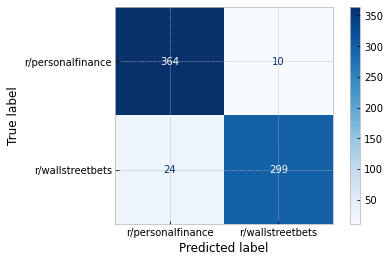

In [47]:
print('Confusion Matrix of the Final Model:')
plot_confusion_matrix(gs_cvec_stem, X_stem_test, y_stem_test, cmap='Blues', 
                      values_format='d', display_labels=['r/personalfinance', 'r/wallstreetbets']);

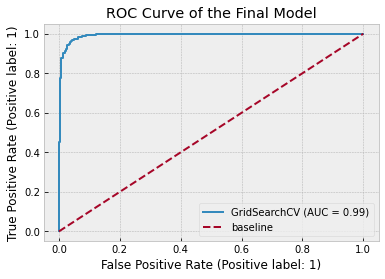

In [48]:
plot_roc_curve(gs_cvec_stem, X_stem_test, y_stem_test)
plt.plot([0,1], [0,1], label = 'baseline', linestyle = '--')
plt.title('ROC Curve of the Final Model')
plt.legend();

In [49]:
predic_proba = gs_cvec_stem.predict_proba(X_stem_test)
print(f'The AUC Score of the final model is: {roc_auc_score(y_stem_test, predic_proba[:,1])}.')

The AUC Score of the final model is: 0.9937004354232546.


### Model Thresholds

Based on the ROC curve of the graph, and the AUC score, the model has a very good ability to differentiate between posts from the two subreddits.

However, because our Sensitivity score, our key marker, is the lowest of the matrix scores we are observing, at 0.925, exploring adjusting the threshold of the probability of predicting a body of text to be from r/wallstreetbets will allow us to tune to this score and lower the chance of false negatives. 

In [50]:
get_predictions(gs_cvec_stem, X_stem_test, y_stem_test, 0.4)

For the threshold of 0.4: 
True Negatives: 364 
False Positives: 10 
False Negatives: 24 
True Positives: 299 
-------------------------- 
Specificity is 0.9732620320855615 
Sensitivity score is 0.9256965944272446 
Precision score is 0.9676375404530745


In [51]:
get_predictions(gs_cvec_stem, X_stem_test, y_stem_test, 0.25)

For the threshold of 0.25: 
True Negatives: 364 
False Positives: 10 
False Negatives: 19 
True Positives: 304 
-------------------------- 
Specificity is 0.9732620320855615 
Sensitivity score is 0.9411764705882353 
Precision score is 0.9681528662420382


In [52]:
get_predictions(gs_cvec_stem, X_stem_test, y_stem_test, 0.1)

For the threshold of 0.1: 
True Negatives: 362 
False Positives: 12 
False Negatives: 17 
True Positives: 306 
-------------------------- 
Specificity is 0.9679144385026738 
Sensitivity score is 0.9473684210526315 
Precision score is 0.9622641509433962


Adjusting the model's threshold for probabilities does help increase the Sensitivity of the model, reducing false negatives from 24 to 17, while only increasing the number of false positives by 2. This increases our sensitivity from 0.925 to 0.947.

Misclassification rate actually reduced, despite the the lowering of the threshold to accept a high number of false negatives.

### Most Important Features (Words) in the Model

In [53]:
log_prob_pos = gs_cvec_stem.best_estimator_['nb'].feature_log_prob_[1] # Coef log probabilities for personalfinance
log_prob_neg = gs_cvec_stem.best_estimator_['nb'].feature_log_prob_[0] # Coef log probabilities for wallstreetbets
log_prob_difference = log_prob_pos - log_prob_neg

prob_word_list = sorted(zip(gs_cvec_stem.best_estimator_[0].get_feature_names(), log_prob_difference), 
                      key = lambda x: abs(x[1]), reverse = True)
prob_word_list

[('dd', 5.201877333586583),
 ('irnt', 5.098157507386217),
 ('ira', -5.045802578585896),
 ('ape', 5.041962949042575),
 ('gamma', 5.018570069467869),
 ('iv', 4.976267689777179),
 ('roth', -4.935634361359966),
 ('metal', 4.650845289342552),
 ('squeez', 4.624869802939291),
 ('retard', 4.59820155585713),
 ('spac', 4.5615001890067015),
 ('mo', -4.553979901945521),
 ('lucid', 4.4938415405328875),
 ('hsa', -4.401788086603595),
 ('redempt', 4.307511962341394),
 ('revenu', 4.270697989218677),
 ('accdist', 4.219404694831127),
 ('canoo', 4.219404694831127),
 ('despac', 4.219404694831127),
 ('launch', 4.151351231586111),
 ('tesla', 4.137166596594155),
 ('beta', 4.122777859142055),
 ('india', 4.122777859142055),
 ('retir', -4.104009553900806),
 ('hedg', 4.10079895242328),
 ('renew', 4.0933639739357615),
 ('catalyst', 4.0630586244404325),
 ('degener', 4.0630586244404325),
 ('uranium', 4.0630586244404325),
 ('marri', -4.023351650883351),
 ('si', 3.999545218718107),
 ('merger', 3.9662087984505154),
 ('

In [54]:
plot_prob_word_list = pd.DataFrame(columns = ['word', 'log_prob_diff'],
                                 data = prob_word_list).head(50)

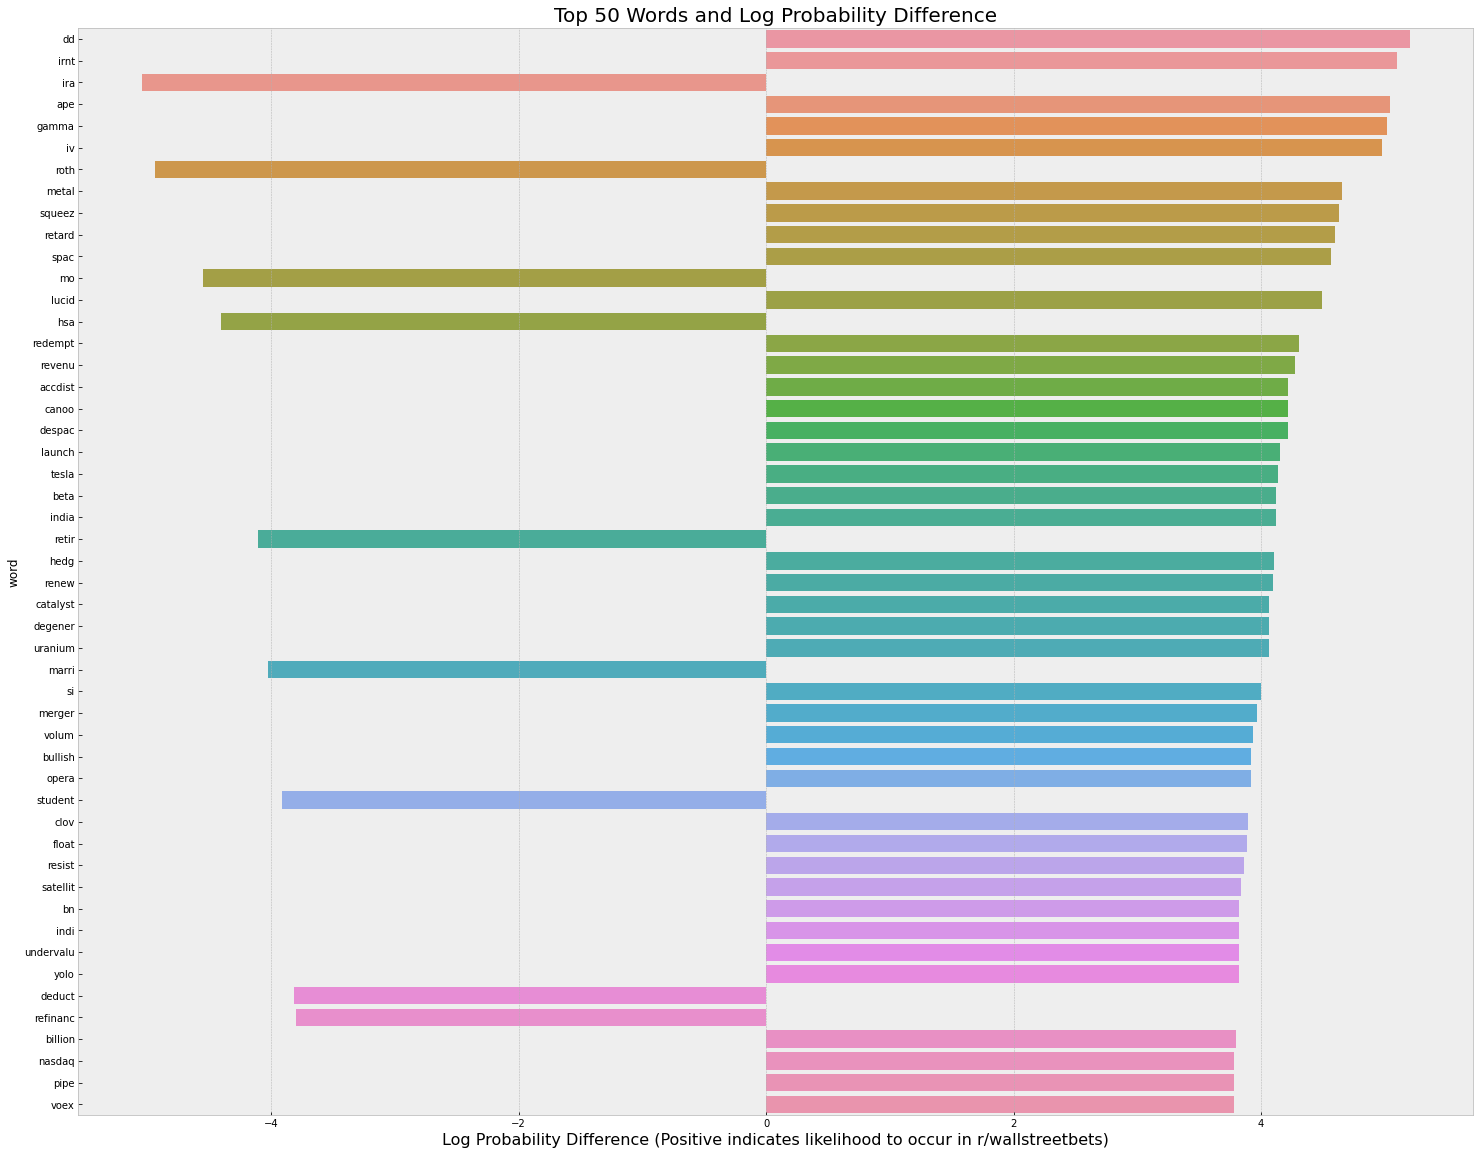

In [74]:
plt.figure(figsize = (25,20))
sns.barplot(
    y = 'word',
    x = 'log_prob_diff',
    data = plot_prob_word_list
)
plt.title('Top 50 Words and Log Probability Difference', fontsize = 20)
plt.xlabel('Log Probability Difference (Positive indicates likelihood to occur in r/wallstreetbets)', fontsize = 16);

One interesting thing to note when observing the top 50 words that contribute to the classifier model, is the heavy reliance on words that feature into r/wallstreetbets, rather than r/personalfinance.

The words that do indicate that posts from r/personalfinance are close to what was originally predicted:
- ira
- roth
- mo
- hsa
- retir
- marri
- student
- deduct

With the exception of mo (month), which indicates a shorter time line than we predicted, everything else has to do with retirement, retirement accounts, and budgeting/finance.

On the other hand, while words that predict r/wallstreetbets does have a lot more to do with:
- financial terms (dd or due diligence, gamma, revenue)
- meme terms (ape, metal)

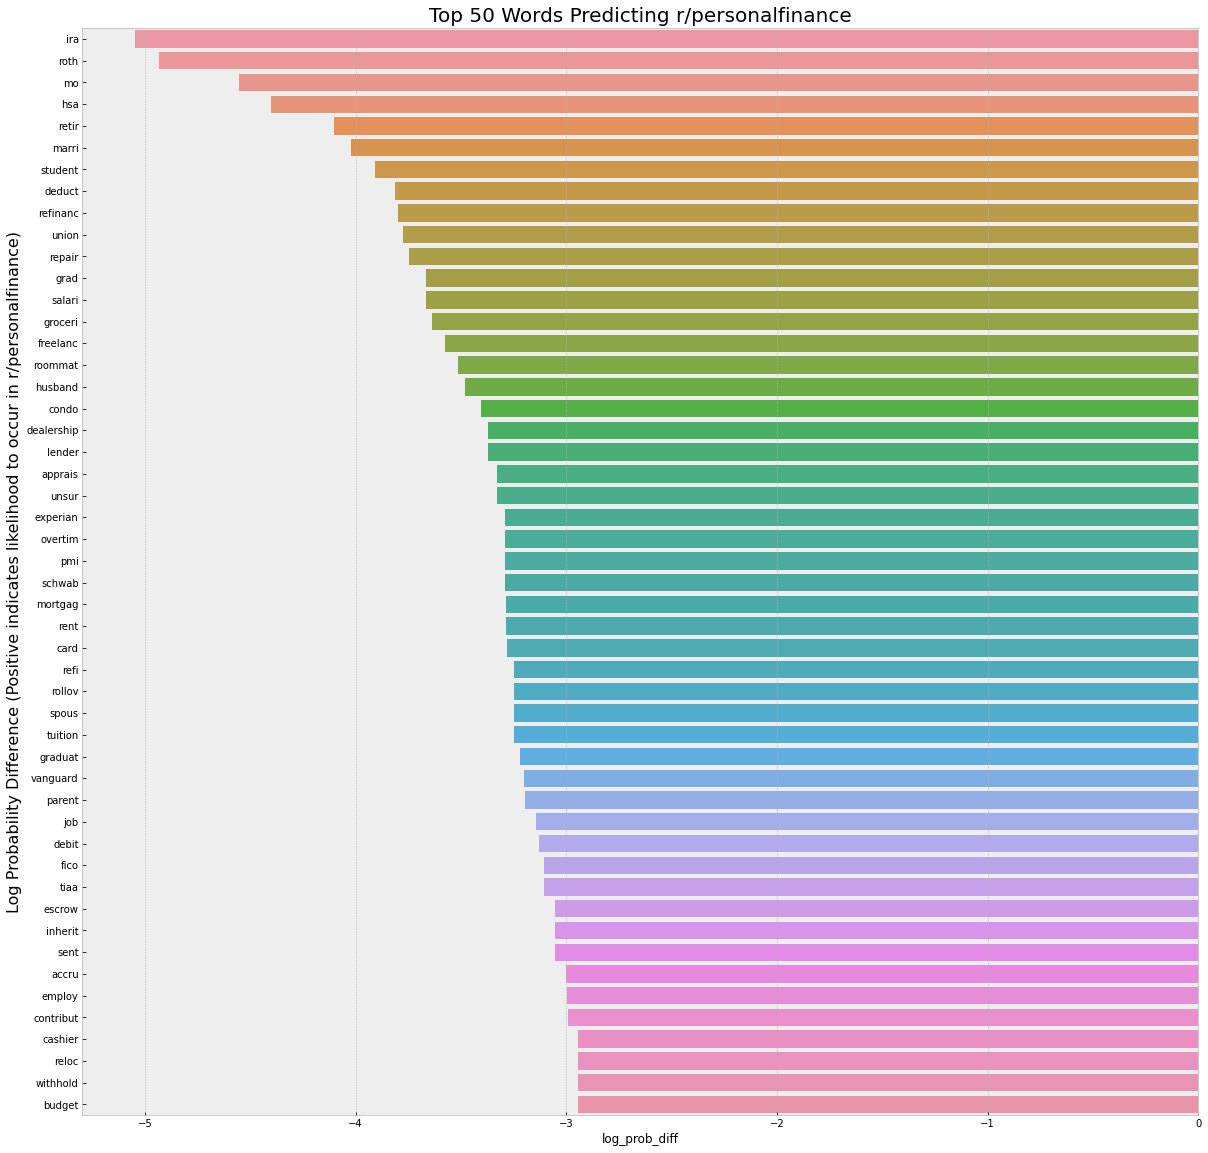

In [56]:
pf_prob_word_list = sorted(zip(gs_cvec_stem.best_estimator_[0].get_feature_names(), log_prob_difference), 
                      key = lambda x: x[1], reverse = False)

plot_pf_prob_word_list = pd.DataFrame(columns = ['word', 'log_prob_diff'],
                                 data = pf_prob_word_list).head(50)

plt.figure(figsize = (20,20))
sns.barplot(
    y = 'word',
    x = 'log_prob_diff',
    data = plot_pf_prob_word_list
)
plt.title('Top 50 Words Predicting r/personalfinance', fontsize = 20)
plt.ylabel('Log Probability Difference (Positive indicates likelihood to occur in r/personalfinance)', fontsize = 16);

A closer examination of the top 50 words predicting posts belonging in r/personalfinance do confirm what was initially put forward, that the words do correspond more with the following general categories:

|Category|Examples|
|--|--|
|Retirement|retirement, ira|
|Financial Relationships|marriage, spouse, roommate, husband|
|Daily Finance|tuition, salary, groceries|
|Index Funds (as opposed to single stocks)|vanguard|
|Big Financial Decision/Windfall|condos, dealership, refinance|

### Wrongly Classified Posts

In [57]:
predictions = gs_cvec_stem.predict(X_stem_test)
results = pd.concat(objs = [
    (pd.DataFrame(columns = ['predictions'], data = predictions)),
    y_stem_test.reset_index()
], axis = 1)
wrong_preds = results[results['is_wallstreetbets'] != results['predictions']].index  # Indices of wrong predictions only

In [58]:
# DataFrame of Tokenized Words
cvec_array = pd.DataFrame(columns = gs_cvec_stem.best_estimator_['cvec'].get_feature_names(),
                          data = gs_cvec_stem.best_estimator_['cvec'].transform(X_stem_test).todense())

In [59]:
indicative_words = [word for word, val in prob_word_list[:50]]                  # top 50 differentiating words
checked_words = [word for word in indicative_words if word in cvec_array.columns]    # Only include words in the columns
cvec_indicative_words = pd.concat(objs = [
    results[['is_wallstreetbets', 'index']],
    cvec_array[checked_words]
], axis = 1
)

cvec_indicative_words.set_index('index', inplace = True)
cvec_indicative_words = cvec_indicative_words.iloc[wrong_preds, :]                   # Only rows with wrong predictions

In [60]:
pd.set_option("display.max_columns", None)                                           # Display all columns

In [61]:
cvec_indicative_words.groupby('is_wallstreetbets').sum()

,dd,irnt,ira,ape,gamma,iv,roth,metal,squeez,retard,spac,mo,lucid,hsa,redempt,revenu,accdist,canoo,despac,launch,tesla,beta,india,retir,hedg,renew,catalyst,degener,uranium,marri,si,merger,volum,bullish,opera,student,clov,float,resist,satellit,bn,indi,undervalu,yolo,deduct,refinanc,billion,nasdaq,pipe,voex
is_wallstreetbets,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0


#### False Positives

In [62]:
# False Positives
cvec_indicative_words[cvec_indicative_words['is_wallstreetbets'] == 0
                     ].drop(columns = 'is_wallstreetbets').sum().sort_values(ascending = False).head(5)

merger      4
revenu      2
retir       1
dd          0
catalyst    0
dtype: int64

For the 10 posts that were false positives, there are very few indicative words from the top 50 most predictive words.

In [63]:
fp_list = cvec_indicative_words[cvec_indicative_words['is_wallstreetbets'] == 0].index
pd.set_option('display.max_colwidth', -1)
reddit_clean.iloc[fp_list, [7]].describe()

<ipython-input-63-7c39c6cfa12a>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,word_count
count,10.000000
mean,85.200000
std,55.008686
min,24.000000
25%,36.750000
50%,74.500000
75%,113.000000
max,173.000000


The mean and media for the false positive posts are higher than expected, with a mean of 120 and a median of 73. While all the posts lie within 2 standard deviations of the mean, indicating that most posts are long for reddit, none of them are excessively so either. There are also very few posts, 10 total, which can heavily influence the metrics.

That said, we have seen that posts from r/personalfinance are longer than wallstreetbets in general, and as such, these are well within the range of what is normal for the subreddit.

In [64]:
false_positive_posts = reddit_clean.iloc[fp_list, :]
false_positive_posts.loc[(false_positive_posts['word_count'] > 120),   # Above the mean
                         ['title', 'selftext']]

,title,selftext
1003,which company should i join now that will return facebook like returns for early employees and vest in?,there are a few ways to build wealth in our country. real estate is a big one. investing in retirement accounts and owning some total stock index funds are a great way too. starting a startup is hard because most fail but selling subscriptions to saas tools is tried and true but too much work. i rarely see people talk about joining the right company at an early stage. \n\na great way to build wealth in a short amount of time is to join a high trajectory startup and get some equity. if they grow and go public or sell to a big co then you’re kinda set for life. there are websites like breakoutlist that try and figure this out but who out there can recommend startup to join that will make one a cool million or more in about 4 years. taking any and all thoughts into account.
766,new proposed congress laws?,"hey everyone!\n\njust got an email from my credit union that said the following:\n\n &gt; as congress considers new infrastructure spending, lawmakers are considering unconventional sources of revenue to fund their plans. one proposal under consideration would require financial institutions like your federal credit union to report to the internal revenue service (irs) many activities on accounts with balances over $600. such an unprecedented grab of your personal financial data raises several concerns.\n\n &gt; * this proposal would violate the personal privacy of consumers like you by forcing financial institutions to provide the government with information that does not reflect taxable activity.\n\n &gt; * financial institutions would face a new, expensive regulatory burden.\n\n &gt; * the decades-old data systems the government stores irs information on have been compromised in recent years. adding this type of data only increases the likelihood of a future breach of your personal financial information.\n\nis this for real? if so, what can we do to protect ourselves from something like this? this is a huge government overreach."


Reading through the longer posts, the 1st deals looks like a advice seeking column but does end up looking more like a desire for getting rich, rather than the standard fare of r/personalfinance, which is probably why it was misclassified.

The 2nd involves a strange post that is part advice seeking, part advocacy for politics, which we are trying to catch to further examine.

Overall, because the Specificity is so high, and as previously stated, we are really trying to maximise sensitivity, the false positive posts may be considered acceptable. 

#### False Negatives

In [65]:
cvec_indicative_words[cvec_indicative_words['is_wallstreetbets'] == 1
                     ].drop(columns = 'is_wallstreetbets').sum().sort_values(ascending = False).head(5) 

hsa          3
undervalu    2
yolo         1
student      1
dd           0
dtype: int64

For posts that were false negatives, few words were from the top 50 most predictive words, which might help to explain some of the misclassification.

In [66]:
fn_list = cvec_indicative_words[cvec_indicative_words['is_wallstreetbets'] == 1].index
pd.set_option('display.max_colwidth', -1)
reddit_clean.iloc[fn_list, [7]].describe()

<ipython-input-66-840eb374b205>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,word_count
count,24.000000
mean,56.250000
std,39.075457
min,2.000000
25%,35.500000
50%,45.500000
75%,64.250000
max,166.000000


Additionally, word count for the misclassified posts were very low, with a median word count <45. This is considering word count here refers to both title and selftext. A lower word count makes it togher for the model to distinguish between the two subreddits.

Only 4 posts lie outside 1 standard deviation from the mean.

In [67]:
false_negative_posts = reddit_clean.iloc[fn_list, :]
false_negative_posts.loc[(false_negative_posts['word_count'] > 95),   # above 1 standard deviation from mean (56+39)
                         ['title', 'selftext']]

,title,selftext
2225,help a brother out,so currently i am a college student wanting to continue cyber security. i do like trading stocks and the whole aspect of the stock market. webull has this amazing referall program where i can get an apple share if i refer 3 people! i plan to use this money for college tuition since i recently been going through some tough times because of corona and sadly missed the financial aid deadline. if anyone could sign up and i think you just need to deposit 100 bucks then withdraw it right after. it would help me a ton! thanks \n\nhttps://a.webull.com/iq6pxb8adeto7ih2og
2578,rycey. rolls royce,wondering why the stock is not moved much in the last few months especially. air travel has somewhat resumed as well as the electric program they seem to have in place for both marine and air travel. i have some money invested in them and thinking about adding more. but i’m not sure why it really hasn’t taken off yet. \n\nis there something that i missing? does anyone have any thoughts or any vested interest in this company at the current time?\n\nlove to know any more insight to help along before i invest further. i do believe this company will eventually hit the $10 mark i just expected them to be moving on the uptick a little quicker then they have. \n\n[rolls royce electric plane](https://www.rolls-royce.com/media/press-releases/2021/15-09-2021-rr-all-electric-spirit-of-innovation-takes-to-the-skies-for-the-first-time.aspx)
1891,i'm learning and wanted to ask a question about buy a long call option. if this isn't the right place i'm sorry,i was told to ask here about buying an option for uec for the next year. i wanted to grab it since the price dropped but it's estimated over the next 12 months to go between high $3 and low $5 https://money.cnn.com/quote/quote.html?symb=uec i used option calculator and said i had a 49% of profits. is there something else i should look into before buying an option like this? is there something i'm missing? if i'm in the wrong place let me know and i'll delete. sorry if i am and thanks for any help you can give
2643,$axp why would you not invest in credit cards?,"there are so many reasons to invest in in amex right now, it is beyond undervalued for the time we are living in now. consumerism is at an all time high and $axp is just inches away from soaring to its valued number. i would be shocked if it doesnt hit $200 by the end of the year.\n\nit's increased in just the past year alone way above pre-covid numbers. americans are buying so many things and keeping the credit card companies at bay while they are slowly collecting that sweet sweet interest money. \ni think now is the time to buy in the dip and ride the wave to $200 ++\n\n$axp has been deemed as undervalued many times in the recent years and every time it has shot up in price to prove its point that amex is not to be trifled with\n\n\nmy position for tomorrow:\n\n[buying $200 dollars worth because my daughter told me too](https://www.youtube.com/watch?v=lbzlzyqnh4s)"


Of the 4 misclassified posts, the 2nd and 3rd do read more like a post that is asking for advice and less like the type of posts we are trying to capture -- pushing a specific point of view or pushing a specific fad.

Work on the model should continue to try to filter out posts 1 and 4. It does look like they managed to sneak through due to certain key words that are highly correlated with r/personalfinance, like college tuition, credit cards and interest.

One consideration to try to have these removed is to try a model with semantic emphasis, rather than our current models which test based on independent word probabilities.

## Conclusions

### Model Efficacy

Our final model was a **Multinomial Naive Bayes** model, with **stemmed words**, **count vectorized** with the following parameteres:

Max Features : 5000
N Gram range: 1, 1
Stop Words: English + a custom stop list

Overall, the model performed very well, identifying posts with a 95.12% accuracy, and when the threshold was adjusted, sensitivity was raised to 94.7%. However, it ultimately let 2 posts through that should be checked. Further steps to improve the model have been listed further below.


### Model Takeaways
As hypothesised at the start, the difference between the two subreddits held fairly consistent, and where it did not, misclassification occurred. In general, posts from r/personalfinance did post more content related to long-term investing for retirement, general advice on budgeting, and maintaining a responsible, sustainable financial lifestyle. All of which are related to the type of content that we would like to pass unchecked.

In contrast, r/wallstreetbets contained many more financially specific terms, which though not exactly the ones initially suspected, were along the lines of what was hypothesised. Further reinforcing this, was the general rule, that the words that most indicated which subreddit the post belonged to were overwhelmingly words from r/wallstreetbets. This seems to indicate and agree with the initial hypothesis that there is a specific type of language and lingo that persists in r/wallstreetbets.


### Further Steps

#### Titles
Improvements to the model could include examining whether titles need to be weighted differently. Titles are often summaries and can contain some of the most important words, and also have the least stopwords. Weighting just the titles differently may give us a better indicator for prediction

#### Word Context
The models tested in this project assumed that the words were independent of each other and that context and semantics were unrelated. However, we know this to not be true and one further direction to take the project would be to include context and semantics into the weighting of the words.

#### Metadata
While we did not include anything related to metadata, a model that includes word count may help in both differentiating, as well as in actually segregating financial news spam. We have already noted that r/personalfinance has a higher word count on average, and this may be partly due to the nature of the posts. Posts seeking or giving advice tend to have more details and more steps, than posts that expound a certain action. 